# small msprime tutorial

## import libraries

In [12]:
import msprime
import numpy as np
from scipy.stats import beta
from scipy.special import gamma
import scipy.integrate as integrate
import matplotlib.pyplot as plt

## simulate 1-locus neutral coalescent, draw tree

In [2]:
tree_sequence = msprime.simulate(sample_size=8, Ne=1000)
tree = tree_sequence.first()
print(tree.draw(format="ascii"))

      14         
 +----+---+      
 |        13     
 |     +--+--+   
 |     |     12  
 |     |    +++  
 |     11   | |  
 |   +-+-+  | |  
 |   |   10 | |  
 |   |  +++ | |  
 |   9  | | | |  
 |  +++ | | | |  
 8  | | | | | |  
+++ | | | | | |  
0 2 1 4 3 7 5 6  



## simulate neutral coalescent with recombination and plot all trees

In [11]:
tree_sequence = msprime.simulate(
    sample_size=6, Ne=1000, length=1e4, recombination_rate=2e-8)
for tree in tree_sequence.trees():
    print("-" * 20)
    print("tree {}: interval = {}".format(tree.index, tree.interval))
    print(tree.draw(format="ascii"))

--------------------
tree 0: interval = (0.0, 2827.621647815132)
     12      
  +--+--+    
  |     9    
  |   +-++   
  |   |  8   
  |   | +++  
  7   | | |  
+-++  | | |  
|  6  | | |  
| +++ | | |  
5 2 4 3 0 1  

--------------------
tree 1: interval = (2827.621647815132, 3509.8523002839306)
     13      
  +--+--+    
  |     9    
  |   +-++   
  |   |  8   
  |   | +++  
  7   | | |  
+-++  | | |  
|  6  | | |  
| +++ | | |  
5 2 4 3 0 1  

--------------------
tree 2: interval = (3509.8523002839306, 6457.299254009803)
    13       
 +--+-+      
 |    10     
 |  +-+-+    
 9  |   |    
+++ |   |    
| | |   7    
| | | +-++   
| | | |  6   
| | | | +++  
3 0 1 5 2 4  

--------------------
tree 3: interval = (6457.299254009803, 10000.0)
    11       
 +--+-+      
 |    10     
 |  +-+-+    
 9  |   |    
+++ |   |    
| | |   7    
| | | +-++   
| | | |  6   
| | | | +++  
3 0 1 5 2 4  



## function to run replicates and calculate expected and observed number of segregating sites

In [9]:
def segregating_sites_example(n, theta, num_replicates):
    S = np.zeros(num_replicates)
    replicates = msprime.simulate(
        Ne=0.5,
        sample_size=n,
        mutation_rate=theta / 2,
        num_replicates=num_replicates)
    for j, tree_sequence in enumerate(replicates):
        S[j] = tree_sequence.num_sites
    # Now, calculate the analytical predictions
    S_mean_a = np.sum(1 / np.arange(1, n)) * theta
    S_var_a = (
        theta * np.sum(1 / np.arange(1, n)) +
        theta**2 * np.sum(1 / np.arange(1, n)**2))
    print("              mean              variance")
    print("Observed      {}\t\t{}".format(np.mean(S), np.var(S)))
    print("Analytical    {:.5f}\t\t{:.5f}".format(S_mean_a, S_var_a))

## run lots of replicates

In [10]:
segregating_sites_example(10, 5, 100000)

              mean              variance
Observed      14.17025		52.98560493749999
Analytical    14.14484		52.63903


## custom script to plot site frequency spectrum and do Tajima's D test

In [21]:
def sfs_example(n, theta):
    tree_sequence = msprime.simulate(sample_size=n, Ne=0.5, mutation_rate=theta/2)
    xi = np.zeros(n-1)
    for i in tree_sequence.variants():
        xi[sum(i.genotypes)-1] += 1
    #print(xi) #print SFS
    k_hat = 1/(n*(n-1)/2) * sum([(j+1)*(n-(j+1))*xi[j] for j in range(n-1)])
    S = tree_sequence.num_sites
    a_1 = sum([1/(i+1) for i in range(n-1)])
    a_2 = sum([1/((i+1)**2) for i in range(n-1)])
    b_1 = (n + 1)/(3*(n-1))
    b_2 = 2*(n**2 + n + 3)/(9*n*(n-1))
    c_1 = b_1 - 1/a_1
    c_2 = b_2 - (n + 2)/(a_1 * n) + a_2/(a_1**2)
    e_1 = c_1/a_1
    e_2 = c_2/(a_1**2 + a_2)
    D = (k_hat - S/a_1) / ((e_1*S + e_2*S*(S-1))**(1/2))
    print('D = %.2f' %D) #print Tajima's D statistic
    a = (2/n - 1/a_1)/(e_2**(1/2))
    if n % 2 == 0:
        b = ((n+1)/(2*(n-1)) - 1/a_1)/(e_2**(1/2))
    else:
        b = ((n+1)/(2*n) - 1/a_1)/(e_2**(1/2))
    alpha = -(1+a*b)*b/(b-a)
    Beta = (1+a*b)*a/(b-a)
    p_lower = integrate.quad(lambda x: gamma(alpha+Beta)/(gamma(alpha)*gamma(Beta)) * (b-x)**(alpha-1) * (x-a)**(Beta-1) / ((b-a)**(alpha+Beta-1)), a, D) #probability of observing a D lower than that observed given neutral model (=1-p_higher)
    if p_lower[0]<1-p_lower[0]:
        p_value = 2*p_lower[0]
    else:
        p_value = 2*(1-p_lower[0])
    print('p = %.3f' %p_value) #two tailed test (equal weights in the two tails)
    plt.bar([i+1 for i in range(n-1)], xi, width=1, align='center')
    plt.xlabel('# derived copies')
    plt.ylabel('# loci')
    plt.title('Unfolded SFS')
    plt.show(block=True)

## 

D = -0.19
p = 0.913


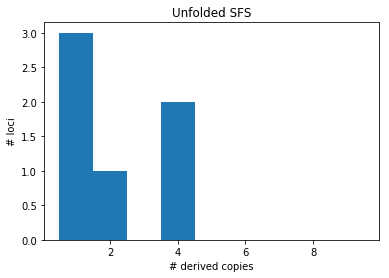

In [22]:
sfs_example(10,5)